In [1]:
# import python libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# load the dataset
file_path = 'Fuel_Consumption_2000-2022.csv'
data = pd.read_csv(file_path)

# display the first few rows of the dataset to understand its structure
data.head()

,YEAR,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,CYLINDERS,TRANSMISSION,FUEL,FUEL CONSUMPTION,HWY (L/100 km),COMB (L/100 km),COMB (mpg),EMISSIONS
0,2000,ACURA,1.6EL,COMPACT,1.6,4,A4,X,9.2,6.7,8.1,35,186
1,2000,ACURA,1.6EL,COMPACT,1.6,4,M5,X,8.5,6.5,7.6,37,175
2,2000,ACURA,3.2TL,MID-SIZE,3.2,6,AS5,Z,12.2,7.4,10.0,28,230
3,2000,ACURA,3.5RL,MID-SIZE,3.5,6,A4,Z,13.4,9.2,11.5,25,264
4,2000,ACURA,INTEGRA,SUBCOMPACT,1.8,4,A4,X,10.0,7.0,8.6,33,198


dataset consists of several columns, including:
- <b>YEAR:</b> Year of the vehicle model.
- <b>MAKE:</b> Manufacturer of the vehicle.
- <b>MODEL:</b> Specific model of the vehicle.
- <b>VEHICLE CLASS:</b> Category of the vehicle (e.g., Compact, Mid-size).
- <b>ENGINE SIZE:</b> Engine size in liters.
- <b>CYLINDERS:</b> Number of cylinders
- <b>TRANSMISSION:</b> Type of transmission.
- <b>FUEL:</b> Type of fuel used.
- <b>FUEL CONSUMPTION HWY (L/100km):</b> Fuel consumption on the highway.
- <b>COMB(L/100 km):</b> Combined fuel consumption (urban + highway).
- <b>COMB(mpg):</b> Combined fuel consumption in miles per gallon.
- <b>EMISSION:</b> CO2 emissions in gram per kilometer.

In [3]:
# data cleaning and preprocessing
# checking for missing values
missing_data = data.isnull().sum()

# checking for duplicates
duplicate_rows = data.duplicated().sum()

missing_data, duplicate_rows

(YEAR                0
 MAKE                0
 MODEL               0
 VEHICLE CLASS       0
 ENGINE SIZE         0
 CYLINDERS           0
 TRANSMISSION        0
 FUEL                0
 FUEL CONSUMPTION    0
 HWY (L/100 km)      0
 COMB (L/100 km)     0
 COMB (mpg)          0
 EMISSIONS           0
 dtype: int64,
 np.int64(1))

In [4]:
# removing the duplicate row
data_cleaned = data.drop_duplicates()

# confirm removal 
duplicate_rows_cleaned = data_cleaned.duplicated().sum()
duplicate_rows_cleaned

np.int64(0)

#### Exploratory Data Analysis (EDA)
1. <b>Yearly Trends:</b> Average fuel consumption and emissions over the years.
2. <b>Comparison by Vehicle Class:</b> Average fuel consumption and emissions by vehicle class.
3. <b>Comparison by Fuel Type:</b> Analysis of fuel consumption based on the type of fuel.
4. Fuel Type Proportions over the Years.
5. <b>Engine Size vs Combined Fuel Consumption</b>.
6. <b>Average Fuel Consumption and Emissions by Cylinder Number</b>.

#### 1. Yearly Trends

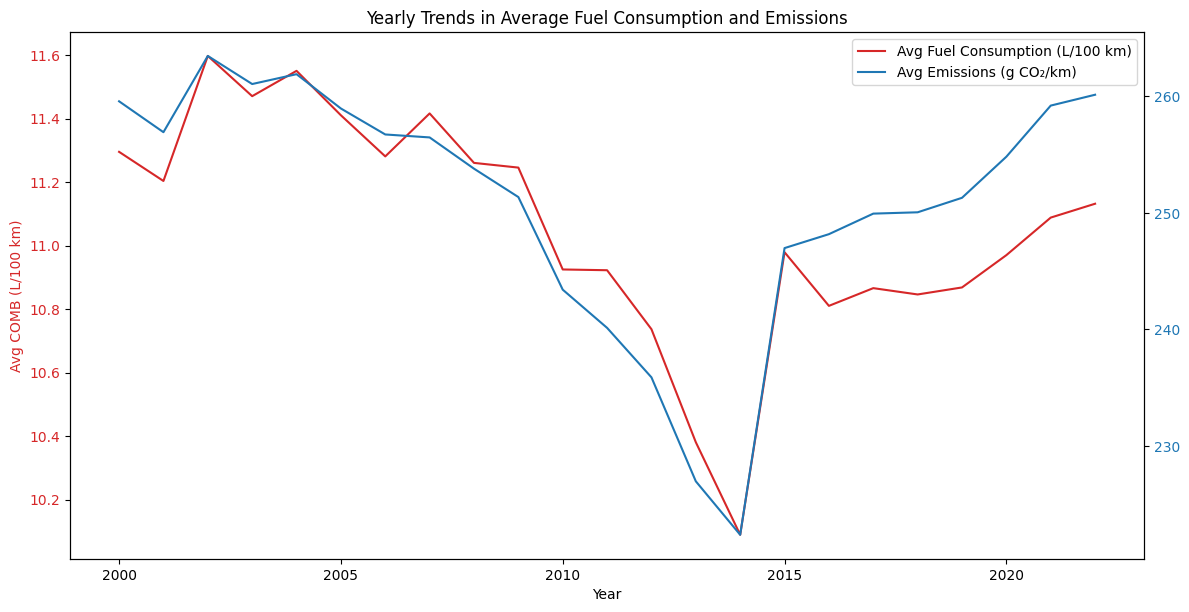

In [5]:
# Yearly trends: Average fuel consumption and emissions over the years
yearly_data = data_cleaned.groupby('YEAR').agg({
    'COMB (L/100 km)': 'mean',
    'EMISSIONS': 'mean'
}).reset_index()

# plotting the trends
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Avg COMB (L/100 km)', color=color)
line1, = ax1.plot(yearly_data['YEAR'], yearly_data['COMB (L/100 km)'], color=color, label='Avg Fuel Consumption (L/100 km)')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
line2, = ax2.plot(yearly_data['YEAR'], yearly_data['EMISSIONS'], color=color, label='Avg Emissions (g CO₂/km)')
ax2.tick_params(axis='y', labelcolor=color)

# combine legends from both axes
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right')

fig.tight_layout() # otherwise the right y-label is slightly clipped
plt.title('Yearly Trends in Average Fuel Consumption and Emissions')
plt.show()

The graph depicts the annual trends in average fuel consumption (liters per 100 kilometers) and emissions (grams per kilometer). Here are a few observations:
- <b>Fuel Consumption:</b> There appears to be a modest decrease in average fuel consumption over time, indicating improved vehicle efficiency.
- <b>Emissions:</b> Similarly, emissions have declined over time, indicating more environmentally friendly vehicle technologies and potentially stronger emission standards.

#### 2. Comparison by Vehicle Class

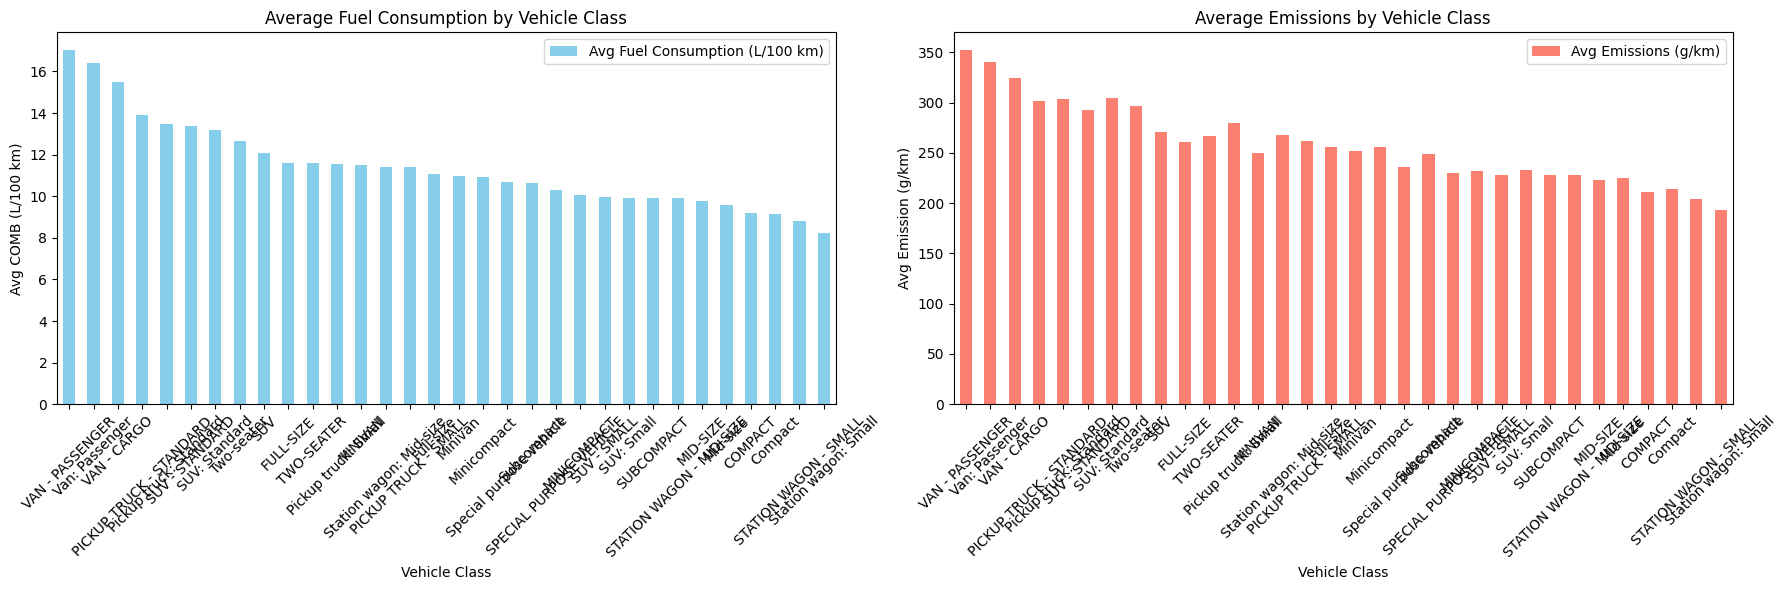

In [6]:
# average fuel consumption and emissions by vehicle class
class_data = data_cleaned.groupby('VEHICLE CLASS').agg({
    'COMB (L/100 km)': 'mean',
    'EMISSIONS': 'mean'
}).sort_values(by='COMB (L/100 km)', ascending=False).reset_index()

# plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# fuel consumption by vehicle class
class_data.plot(x='VEHICLE CLASS', y='COMB (L/100 km)', kind='bar', legend=True, ax=ax1, color='skyblue', label='Avg Fuel Consumption (L/100 km)')
ax1.set_title('Average Fuel Consumption by Vehicle Class')
ax1.set_ylabel('Avg COMB (L/100 km)')
ax1.set_xlabel('Vehicle Class')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper right')

# emissions by vehicle class
class_data.plot(x='VEHICLE CLASS', y='EMISSIONS', kind='bar', legend=True, ax=ax2, color='salmon', label='Avg Emissions (g/km)')
ax2.set_title('Average Emissions by Vehicle Class')
ax2.set_ylabel('Avg Emission (g/km)')
ax2.set_xlabel('Vehicle Class')
ax2.tick_params(axis='x', rotation=45)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

The bar plots provide insights into the average fuel consumption and emissions by vehicle class:
- <b>Fuel Consumption:</b> Larger vehicle classes such as SUVs and pickups tend to have higher average fuel consumption compared to smaller classes like compacts and subcompacts.
- <b>Emissions:</b> Similarly, the emissions are higher for larger vehicle classes. This is consistent with the higher fuel consumption figures.

#### 3. Comparison by Fuel Type

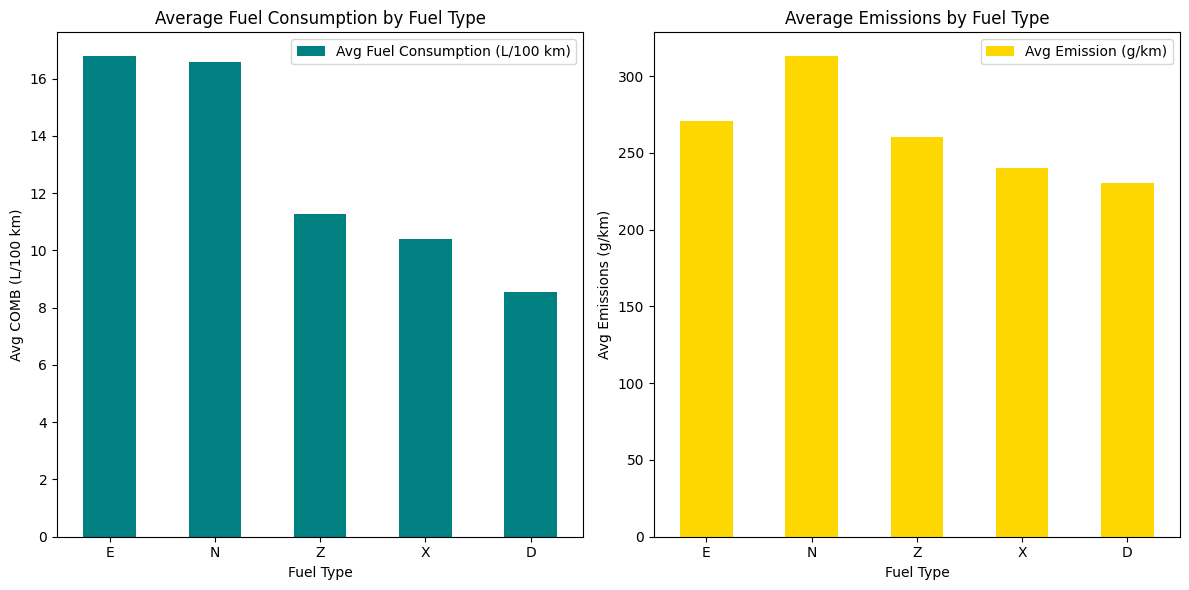

In [7]:
# Average fuel consumption and emissions by fuel type
fuel_type_data = data_cleaned.groupby('FUEL').agg({
    'COMB (L/100 km)': 'mean',
    'EMISSIONS': 'mean'
}).sort_values(by='COMB (L/100 km)', ascending=False).reset_index()

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Fuel Consumption by Fuel Type
fuel_type_data.plot(x='FUEL', y='COMB (L/100 km)', kind='bar', legend=True, ax=ax1, color='teal', label='Avg Fuel Consumption (L/100 km)')
ax1.set_title('Average Fuel Consumption by Fuel Type')
ax1.set_ylabel('Avg COMB (L/100 km)')
ax1.set_xlabel('Fuel Type')
ax1.tick_params(axis='x', rotation=0)
ax1.legend(loc='upper right')

# Emissions by Fuel Type
fuel_type_data.plot(x='FUEL', y='EMISSIONS', kind='bar', legend=True, ax=ax2, color='gold', label='Avg Emission (g/km)')
ax2.set_title('Average Emissions by Fuel Type')
ax2.set_ylabel('Avg Emissions (g/km)')
ax2.set_xlabel('Fuel Type')
ax2.tick_params(axis='x', rotation=0)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

The bar charts illustrate the average fuel consumption and emissions for different types of fuel.
- <b>Fuel Consumption and Emissions:</b> Vehicles that use traditional fuels such as gasoline (referred to as 'X' or 'Z' in some datasets) have higher average fuel consumption and emissions than vehicles that use alternative fuels or more efficient technologies.

#### 4. Fuel Type Proportions Over the Years

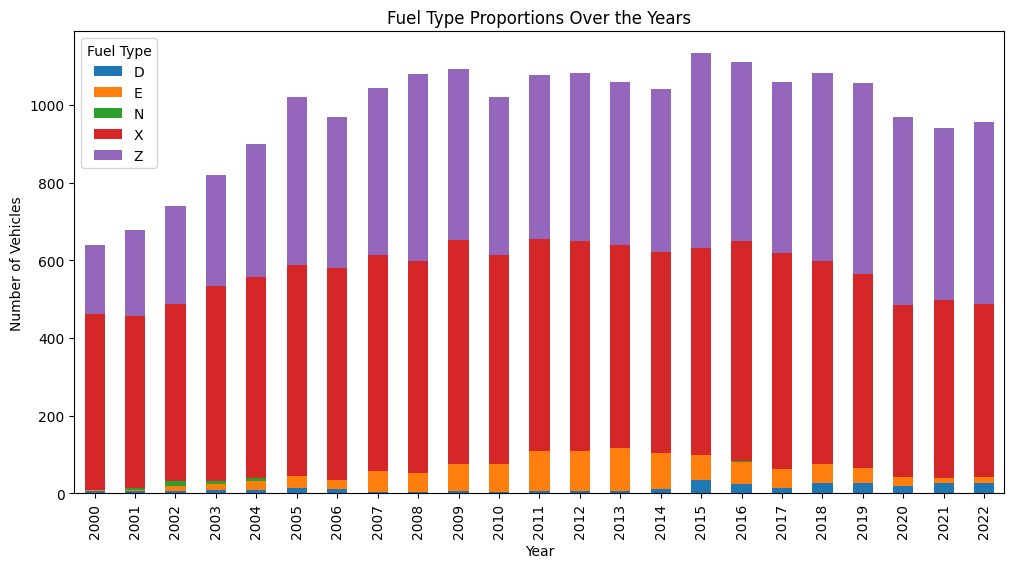

In [8]:
fuel_type_yearly = data_cleaned.groupby(['YEAR', 'FUEL']).size().unstack(fill_value=0)
fuel_type_yearly.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Fuel Type Proportions Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Vehicles')
plt.legend(title='Fuel Type')
plt.show()

This stacked bar figure visualize how the proportions of various types of fuel that used in automobiles have varied over time, illustrating over time, illustrating moves toward more sustainable alternatives.
- <b>Fuel Trends:</b> An increase in the use of alternative fuels such as electric or hybrid vehicles may be noted, indicating a trend toward more environmentally friendly driving options. The reduction of conventional gasoline and diesel fuels can be attributed to increased environmental awareness and restrictions.

#### 5. Engine Size vs Combined Fuel Consumption

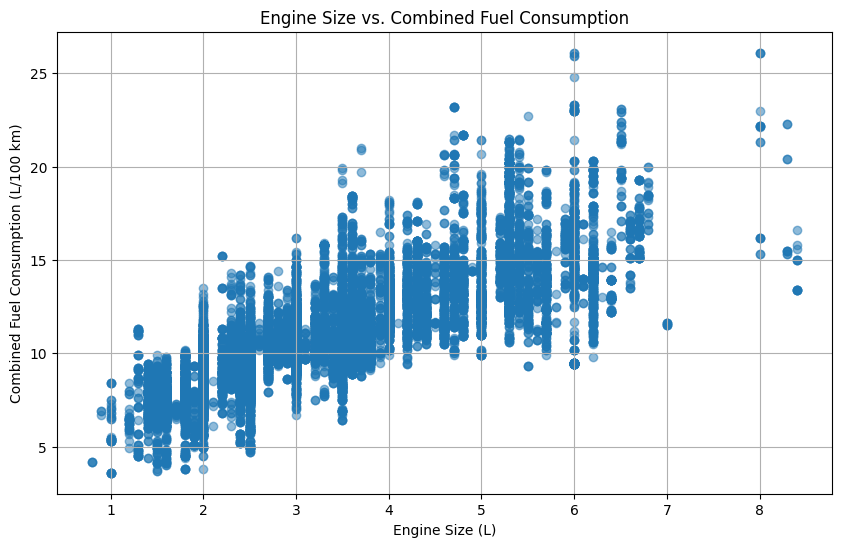

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(data_cleaned['ENGINE SIZE'], data_cleaned['COMB (L/100 km)'], alpha=0.5)
plt.title('Engine Size vs. Combined Fuel Consumption')
plt.xlabel('Engine Size (L)')
plt.ylabel('Combined Fuel Consumption (L/100 km)')
plt.grid(True)
plt.show()

This scatterplot illustrates at the relationship between engine size and overall fuel economy. It investigates the premise that larger engines are less efficient.
- <b>Engine Efficiency:</b> Larger engines often use more fuel, as shown by the positive connection in the scatter figure. However, technology breakthroughs may result in newer models with larger engines attaining higher fuel efficiency, as evidenced by data points that deviate from this trend.

#### 6. Average Fuel Consumption and Emissions by Cylinder Number

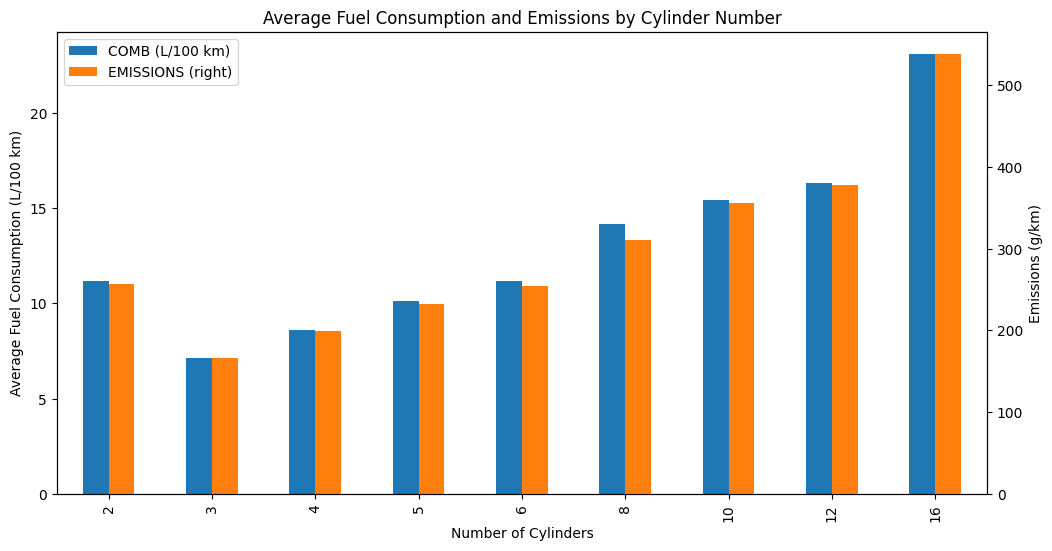

In [10]:
# Use a list instead of a tuple to select multiple columns
cylinder_stats = data_cleaned.groupby('CYLINDERS')[['COMB (L/100 km)', 'EMISSIONS']].mean()
ax = cylinder_stats.plot(kind='bar', secondary_y='EMISSIONS', figsize=(12, 6))
plt.title('Average Fuel Consumption and Emissions by Cylinder Number')
ax.set_xlabel('Number of Cylinders')
ax.set_ylabel('Average Fuel Consumption (L/100 km)')
ax.right_ax.set_ylabel('Emissions (g/km)')  # Access the secondary y-axis
plt.show()

The bar plot display how the number of cylinders in a vehicle influences its fuel consumption and emissions.
- <b>Cylinder Impact:</b> Having more cylinders generally results in increased fuel consumption and emissions since more power takes more fuel. The trends in this plot will reveal whether technological advancements are minimizing this effect in newer models.

#### Exploring and Visualizing the impact of the COVID-19 pandemic
Specifically during the year 2020, compare this data with other years to highlight changes and trends that occurred due to the pandemic. This analysis will involve creating visualizations that compare the average fuel consumption and emissions across different vehicle classes and models for 2020 and the surrounding years for context.

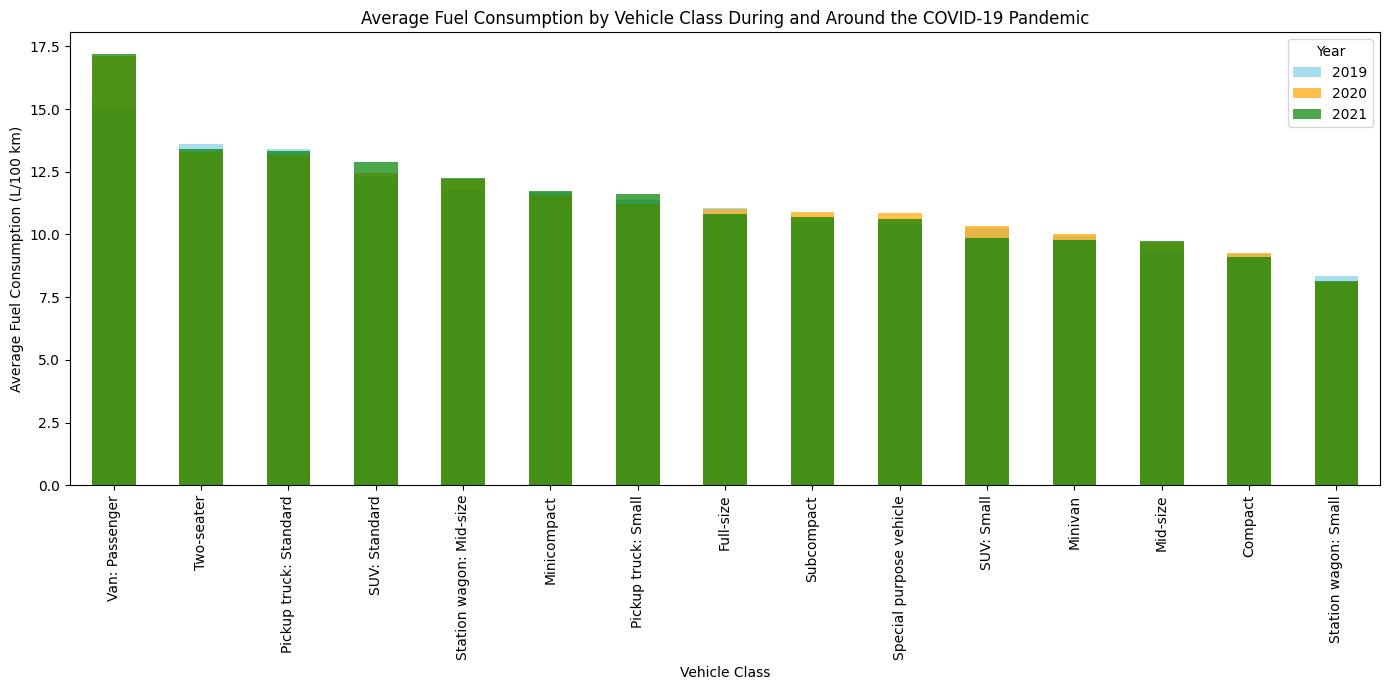

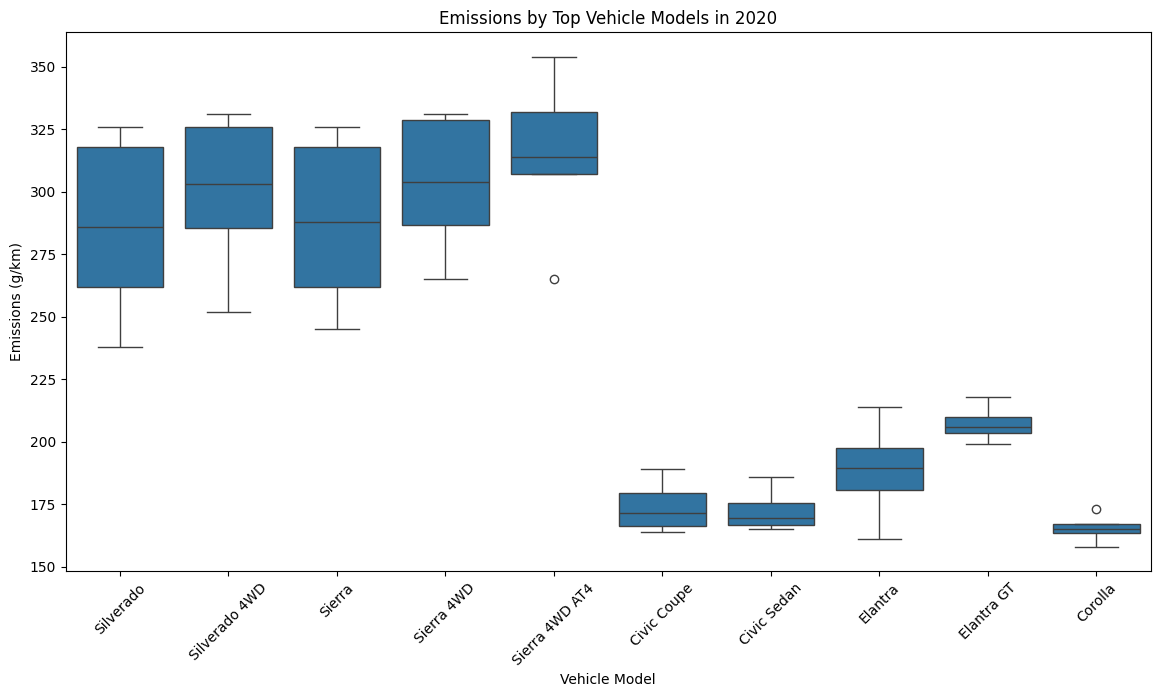

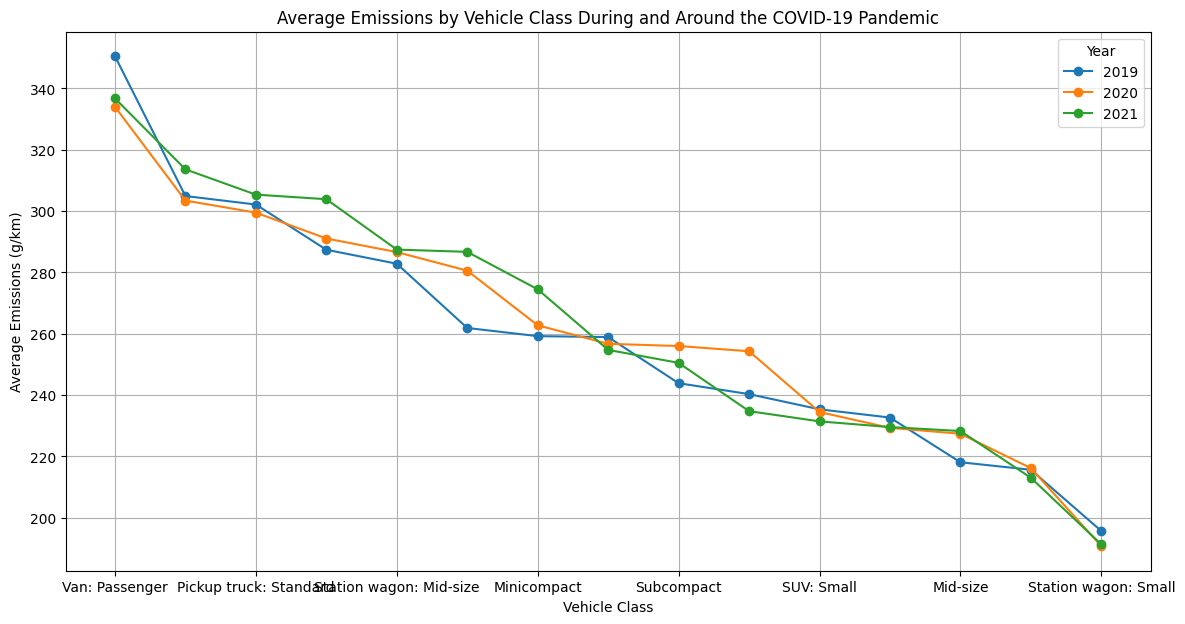

In [11]:
# filter data for relevant years
pandemic_years = data_cleaned[data_cleaned['YEAR'].isin([2019, 2020, 2021])]

# plotting average fuel consumption by vehicle class across 2019, 2020, and 2021
plt.figure(figsize=(14, 7))
colors = {2019: 'skyblue', 2020: 'orange', 2021: 'green'}  
for year in [2019, 2020, 2021]:
    yearly_data = pandemic_years[pandemic_years['YEAR'] == year]
    avg_consumption = yearly_data.groupby('VEHICLE CLASS')['COMB (L/100 km)'].mean()
    avg_consumption.sort_values(ascending=False).plot(
        kind='bar',
        label=f'{year}',
        color=colors[year],
        alpha=0.7  # Slight transparency so overlapping is visible
    )
plt.title('Average Fuel Consumption by Vehicle Class During and Around the COVID-19 Pandemic')
plt.xlabel('Vehicle Class')
plt.ylabel('Average Fuel Consumption (L/100 km)')
plt.legend(title='Year')
plt.tight_layout()
plt.show()

# plotting emissions by vehicle model in 2020
plt.figure(figsize=(14, 7))
top_models = pandemic_years[pandemic_years['YEAR'] == 2020]['MODEL'].value_counts().nlargest(10).index
model_data = pandemic_years[(pandemic_years['MODEL'].isin(top_models)) & (pandemic_years['YEAR'] == 2020)]
sns.boxplot(x='MODEL', y='EMISSIONS', data=model_data)
plt.title('Emissions by Top Vehicle Models in 2020')
plt.xlabel('Vehicle Model')
plt.ylabel('Emissions (g/km)')
plt.xticks(rotation=45)
plt.show()

# compare emissions over the three years
plt.figure(figsize=(14, 7))
for year in [2019, 2020, 2021]:
    yearly_data = pandemic_years[pandemic_years['YEAR'] == year]
    avg_emissions = yearly_data.groupby('VEHICLE CLASS')['EMISSIONS'].mean()
    avg_emissions.sort_values(ascending=False).plot(kind='line', marker='o', label=f'{year}')

plt.title('Average Emissions by Vehicle Class During and Around the COVID-19 Pandemic')
plt.xlabel('Vehicle Class')
plt.ylabel('Average Emissions (g/km)')
plt.legend(title='Year')
plt.grid(True)
plt.show()

#### Explanation of the Plots
1. First plot illustrates <b>the average fuel consumption by vehicle class</b> and chart compares average fuel usage across vehicle classes in 2019, 2020, and 2021. The plot will show whether there was a considerable decrease in fuel use in 2020, when lockdowns and limited travel were frequent.
2. Second plot is about <b>Emissions from Top Vehicle Models in 2020 </b> which focuses on the top ten most frequent car models in 2020, displaying the distribution and outliers in their emissions. This can assist determine which popular models were more or less eco-friendly throughout the pandemic.
3. <b>Average Emissions by Vehicle Class: </b> This line graph plots trends in emissions by vehicle class in 2020 were sustained into 2021 or reversed as limits were eased.

#### Pair plot
visulize relationships and distributions among multiple variables during the COVID-19 pandemic (focusing on the year 2020)

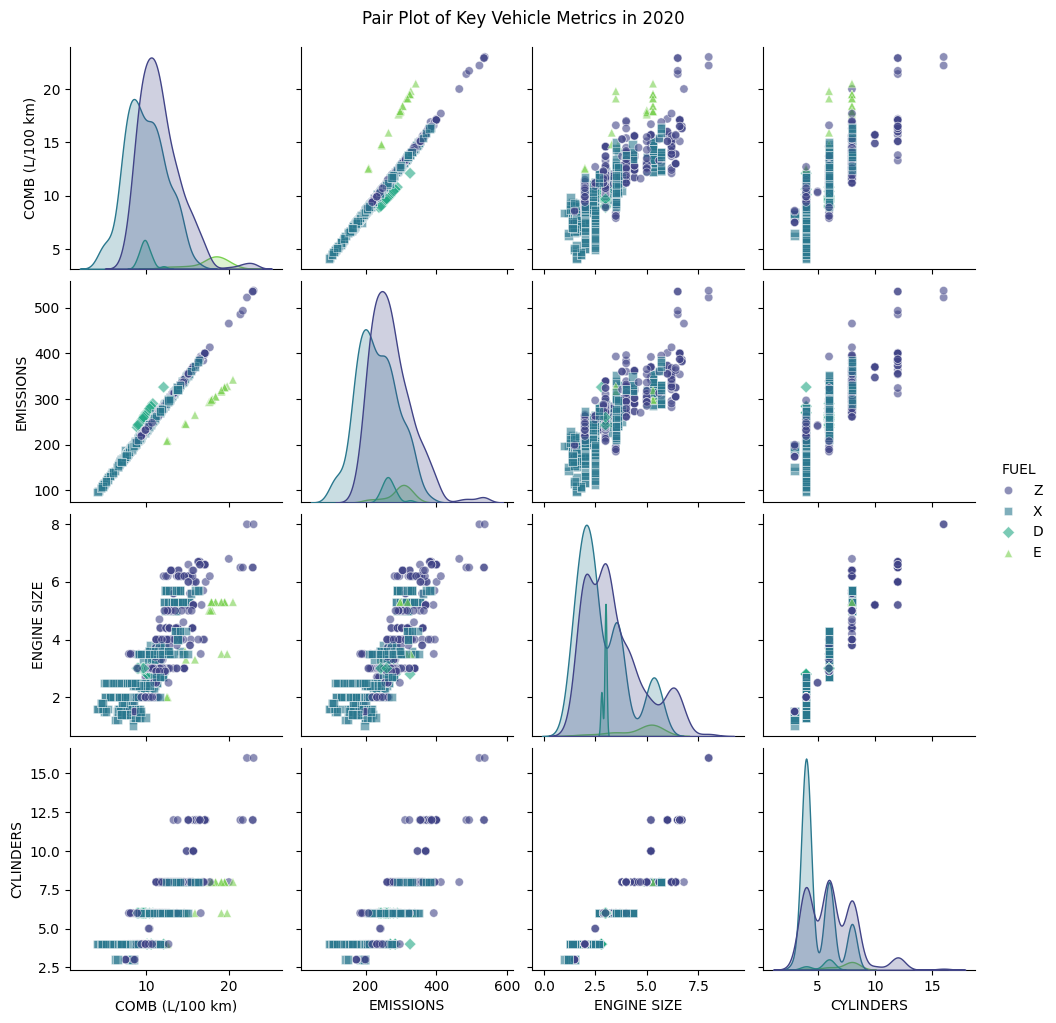

In [12]:
# Filter data for the year 2020
data_2020 = data_cleaned[data_cleaned['YEAR'] == 2020]

# Selecting a subset of columns for the pair plot
columns_to_plot = ['COMB (L/100 km)', 'EMISSIONS', 'ENGINE SIZE', 'CYLINDERS', 'FUEL']
pair_plot_data = data_2020[columns_to_plot]

# Get unique FUEL types and ensure enough markers
unique_fuels = pair_plot_data['FUEL'].unique()
marker_styles = ["o", "s", "D", "^", "v", "<", ">", "P", "X"]

# Create the pair plot
sns.pairplot(
    pair_plot_data,
    hue='FUEL',
    palette='viridis',
    markers=marker_styles[:len(unique_fuels)],
    plot_kws={'alpha': 0.6}
)
plt.suptitle('Pair Plot of Key Vehicle Metrics in 2020', y=1.02)
plt.show()